# Really Big Data
##Gabriel Becton


Today we will be using the MapReduce programming model which allows workflows that are scalable, distributed and robust.  

## MapReduce

MapReduce makes use of two functions, a mapper and a reducer.  The mapper creates a map between essential pieces of information, like creating count lists of each word in a document or record.  The reducer aggregates the output of the mapper, extracting the information that we would like to know.

We will first take a look at how MapReduce works with a very simple word counting example.

The mapper function below takes in a document consisting of words.  The text is first made lowercase and then split into words on whitespace.  The mapper then returns a generator object that we can run a loop over.  The generator yields tuples of a word paired with the number 1, implying that we have found one instance of that word.

In [ ]:
def wc_mapper(document):
    """for each word in the docoument, output (word, 1)"""
    for word in document.lower().split(): 
        yield (word, 1) # yield produces a generator object that you can run
                        # a loop over.  In this case each object is a tuple.

Next, we define a word count reducer.  The reducer takes in a word and a list of count instances.  The reducer sums the counts and returns a generator of word and count sums.

In [ ]:
def wc_reducer(word, counts):
    """sum up the counts for a word"""
    yield (word, sum(counts))

Let's apply our word count mapper and reducer to a set of documents which is just a set of short strings.  Using a MapReduce method for word counts on something this small is crazy overkill but it will let us see how the mapper and reducer work.

In [ ]:
from collections import defaultdict

silly_short_docs = ["data science", "big data", "science fiction"]

collector = defaultdict(list) # start a dictionary of 'key': value pairs where
                              # value is a list

for document in silly_short_docs:
    for word, count in wc_mapper(document): # Iterate over word, count pairs
        collector[word].append(count) # Add the word to the dictionary, if necessary and 
                                      # append a 1 to the list assocated with that word

# Take a look at the collector            
collector

defaultdict(list,
            {'big': [1], 'data': [1, 1], 'fiction': [1], 'science': [1, 1]})

The collector is now a dictionary of words appearing in our "documents".  The keys are the words and the values are lists of ones.  The length of the lists indicates how many times that word appears in our documents.

Now that we have run our mapper and generated the collection of word, count list pairs, we can aggregate using our reducer function.

In [ ]:
for word, countslist in collector.items(): # Iterate over key:value pairs
    for word, count in wc_reducer(word, countslist):
        print('{} {}'.format(word, count))

data 2
science 2
big 1
fiction 1


Now that we have seen the mapper and reducer at work, we can pull it all together by defining the `map_reduce` function.  This function is general enough that we will be able to use it for the rest of this notebook.  If we want to change the type of calculation we are doing, we can simply write new mapper and reducer function to feed to `map_reduce`.

In [ ]:
def map_reduce(inputs, mapper, reducer):
    """runs MapReduce on the inputs using mapper and reducer"""
    collector = defaultdict(list)
    
    for i_input in inputs:
        for key, value in mapper(i_input):
            collector[key].append(value)
            
    return[output
          for key, values in collector.items()
          for output in reducer(key, values)]

The output of `map_reduce` will be the same as previous.

In [ ]:
word_counts = map_reduce(silly_short_docs, wc_mapper, wc_reducer)
word_counts

[('data', 2), ('science', 2), ('big', 1), ('fiction', 1)]

`word_counts` is a list of tuples consisting of each word in our document followed by the number of instances of that word.

## Now for the Really Big Data

For our big data example, we will analyze some Kindle book reviews from Amazon.  A large set of these reviews is stored on Kaggle.

We will first need to set up Kaggle.  You can find your Kaggle information in your kaggle.json file or copy it from your Lab 16 notebook.

In [ ]:
# Replace 'username' with your username from your kaggle.json file
# Replace 'yourkey' with your key from your kaggle.json file
# This key will be a long string of numbers and letters

import os
os.environ['KAGGLE_USERNAME']='gabrielbecton'
os.environ['KAGGLE_KEY']='62a34da3f59850bcad7cf043f0d2a4cd'

Next, to download the data.  The Kaggle website, which includes descriptions of the data is [here](https://www.kaggle.com/bharadwaj6/kindle-reviews/home).  Open the link to take a look at the data columns and what they mean.

In [ ]:
### Download the data
! kaggle datasets download -d bharadwaj6/kindle-reviews

 97% 511M/525M [00:03<00:00, 139MB/s]
100% 525M/525M [00:03<00:00, 145MB/s]


This data set is large enough that we will prefer to work with the zipped files and not plop a couple of huge unzipped files into our Colaboratory workspace.  It is also best to not read the whole csv file into a single Pandas DataFrame.  This process is SLOOOOOOOOOOOOOOWWWW and will take a huge amount of memory.  Unless you have a nice gaming computer with lots of memory, you will probably not want to deal with the files all at once.

Let's deal with the files in their zipped form and check out their sizes.

In [ ]:
from pathlib import Path
import zipfile

kindlerev_path = Path('kindle-reviews.zip')

zf = zipfile.ZipFile(str(kindlerev_path), 'r') 
print([f.filename for f in zf.filelist])

['kindle_reviews.csv', 'kindle_reviews.json']


In [ ]:
print('Uncompressed CSV file size = {}'.format( zf.filelist[0].file_size/1e6))
print('Compressed CSV file size = {}'.format( zf.filelist[0].compress_size/1e6))

Uncompressed CSV file size = 701.881303
Compressed CSV file size = 271.663093


### Create a Database of Data Chunks

Instead of reading the huge csv file into a Pandas DataFrame, one strategy that we can pursue is to read chunks of the data into separate SQL tables.  This has two advantages.  First, by parsing out the data into multiple tables, we could have different computers, or processors each working on a separate table.  The more computers available to us, the faster the work would go.  Secondly, using a database can save a lot of memory because we can query and load into memory only the columns that we need for our calculation.

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

csv_database = create_engine('sqlite:///kindlereviews.db')

In [ ]:
chunksize = 100000 # number of lines to read at once
i = 0 # chunk/table number

with zf.open(zf.filelist[0].filename) as csvfile:
    for df in pd.read_csv(csvfile, chunksize=chunksize, iterator=True):
        tablename = 'table{}'.format(i)
        df.to_sql(tablename, csv_database)
        i+=1
        
# This cell will take a while to run.

How many tables did we generate?

In [ ]:
import sqlalchemy

inspector = sqlalchemy.inspect(csv_database)
inspector.get_table_names()

['table0',
 'table1',
 'table2',
 'table3',
 'table4',
 'table5',
 'table6',
 'table7',
 'table8',
 'table9']

In [ ]:
# Get column information
print('table0 = ')
for col in inspector.get_columns("table0"):
    print(col)

table0 = 
{'name': 'index', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'Unnamed: 0', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'asin', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'helpful', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'overall', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'reviewText', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'reviewTime', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'reviewerID', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'reviewerName', 'type': TEXT(), 'nullable': True, 'defau

### Is there a difference between 1 star reviews and 5 star reviews?

Now we are ready to ask a question of our data.  Is there a difference in the words most commonly used in book reviews based on the book rating given by the reviewer?

We will need to write new mapper and reducer functions to perform this count.

To make our results more interesting, we will first download a list of "stopwords" from the Natural Language ToolKit (NLTK).  "stopwords" are boring words like "a", "and", "the" etc.  We expect that these very common words will be in all of reviews, regardless of the book rating.  

In [ ]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from collections import Counter
import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Our mapper function will take in a review and inspect the number of stars (in the "overall") column and the "reviewText".  As long as the "reviewText" not empty, each word in the "reviewText" will create a (word, 1) tuple that will be associated with the number of stars.

In [ ]:
def words_per_star_mapper(review):
    star = review["overall"]
    if review["reviewText"] is not None:
        for word in re.findall(r'\w+', review["reviewText"].lower()):
            yield(star, (word, 1))

The new reducer function takes in the attribute (in this case stars) and a tuple of (word, count) pairs.  As long as a word is not a stop word, its count is added to word_counts.  The 20 most common words in word_counts is returned.

In [ ]:
def most_pop_word_reducer(attr, words_n_counts):
    """Given a sequence of (word, count) pairs,
    return the top 20 words with the highest total count"""
    
    word_counts = Counter()
    for word, count in words_n_counts:
        if word not in stop_words:
            word_counts[word] += count
        
    pop_list = word_counts.most_common(20)
    
    yield(attr, pop_list)

Next we will read the necessary data from our database into a Pandas DataFrame.  Ideally, we would have access to multiple computers and each table would be handed off to a separate computer.  Since we are running on just one computer, we will read in and use data from just 3 of our tables. 

In [ ]:
sql_str = """
SELECT overall, reviewText 
FROM {tname};
"""

revdf = pd.DataFrame([])

for itable in range(3):
    tname = 'table{}'.format(itable)
    sql_expr = sql_str.format(tname=tname)
    revdf = revdf.append(pd.read_sql(sql_expr, csv_database), ignore_index=True)    

In [ ]:
revdf.head()

Now we can use MapReduce.  Warning: this will take a while unless your computer is very awesome. The method .to_dict('records') splits the Data Frame into a list of dictionaries with one DataFrame row per dictionary.

In [ ]:
star_pop_words = map_reduce(revdf.to_dict('records'), words_per_star_mapper, most_pop_word_reducer)
star_pop_words


Some words, such as 'book', 'read', and 'story' appear commonly in all reviews, regardless of the number of stars.  On the other hand, 'love' moves up the rankings from not being present at all among the top 20 for one star reviews to being the 5th most commonly used non-stop word for 5 star reviews.

Let's make a bar chart!

We will plot ('love' counts)/('book' counts) for 2-5 star reviews.  We will divide the counts for the two words since 'book' appears most often for all star types and will serve as a normalizing factor since there may be a lot more 5 star reviews than 2 star reviews.

In [ ]:
love_counts = []

for star in range(2,6):
    index = 5-star
    love_counts.extend([count for word, count in star_pop_words[index][1] if word == 'love'])
    
love_counts

[2839, 9081, 29784, 67263]

In [ ]:
book_counts = []

for star in range(2,6):
    index = 5-star
    book_counts.extend([count for word, count in star_pop_words[index][1] if word == 'book'])
    
book_counts

[17562, 42324, 94832, 170427]

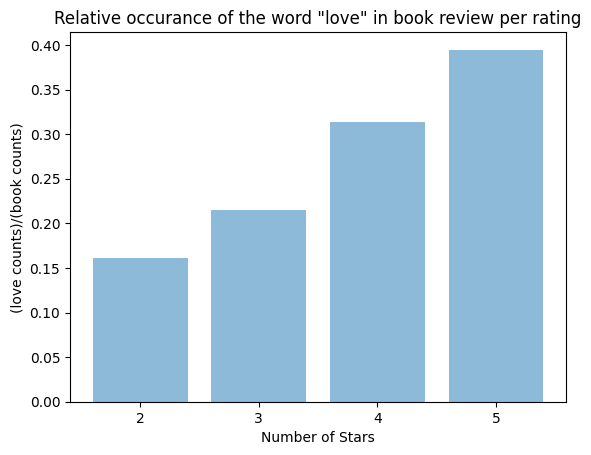

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

love_counts = [np.float(count) for count in love_counts]
book_counts = [np.float(count) for count in book_counts]

love_counts = np.asarray(love_counts)
book_counts = np.asarray(book_counts)

love_book = love_counts/book_counts
star = np.arange(2,6)

y_pos = np.arange(len(star))
 
plt.bar(y_pos, love_book, align='center', alpha=0.5)
plt.xticks(y_pos, star)
plt.ylabel('(love counts)/(book counts)')
plt.xlabel('Number of Stars')
plt.title('Relative occurance of the word "love" in book review per rating')
 
plt.show()

In [ ]:
# Find the most common words used in the review 'summary' 
# using MapReduce
# You should be able to do this via the following steps
# 1. Write a new mapper function that looks at the text in 'summary'
# 2. Read the data from 3 database tables into a DataFrame using an appropriately
# modified query
# 3. Run the map_reduce function with the new DataFrame and your new mapper.

def words_per_star_mapper(review):
    star = review["overall"]
    if review["summary"] is not None:
        for word in re.findall(r'\w+', review["summary"].lower()):
            yield(star, (word, 1))

def most_pop_word_reducer(attr, words_n_counts):
    """Given a sequence of (word, count) pairs,
    return the top 20 words with the highest total count"""
    
    word_counts = Counter()
    for word, count in words_n_counts:
        if word not in stop_words:
            word_counts[word] += count
        
    pop_list = word_counts.most_common(20)
    
    yield(attr, pop_list)
            

In [ ]:
sql_str = """
SELECT overall, summary 
FROM {tname};
"""

revdf = pd.DataFrame([])

for itable in range(3):
    tname = 'table{}'.format(itable)
    sql_expr = sql_str.format(tname=tname)
    revdf = revdf.append(pd.read_sql(sql_expr, csv_database), ignore_index=True)      

In [ ]:
star_pop_words = map_reduce(revdf.to_dict('records'), words_per_star_mapper, most_pop_word_reducer)
star_pop_words


In [ ]:
# Look at the results from TASK 1 and make a plot of an interesting
# trend.

great_counts = []

for star in range(2,6):
    index = 5-star
    great_counts.extend([count for word, count in star_pop_words[index][1] if word == 'great'])
    
great_counts



[239, 1073, 6509, 18274]

In [ ]:
book_counts = []

for star in range(2,6):
    index = 5-star
    book_counts.extend([count for word, count in star_pop_words[index][1] if word == 'book'])
    
book_counts

[674, 1839, 5449, 13303]

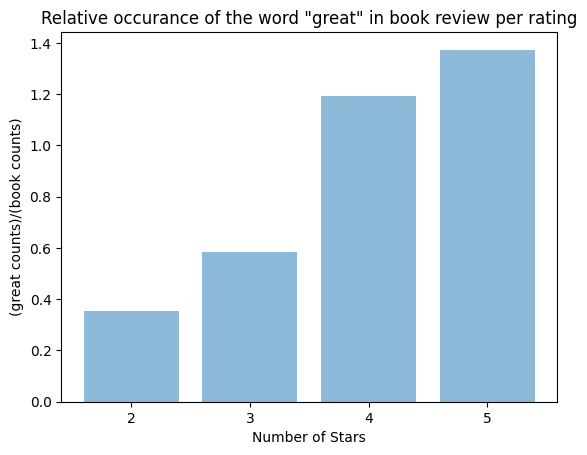

In [ ]:
great_counts = [np.float(count) for count in great_counts]
book_counts = [np.float(count) for count in book_counts]

great_counts = np.asarray(great_counts)
book_counts = np.asarray(book_counts)

great_book = great_counts/book_counts
star = np.arange(2,6)

y_pos = np.arange(len(star))
 
plt.bar(y_pos, great_book, align='center', alpha=0.5)
plt.xticks(y_pos, star)
plt.ylabel('(great counts)/(book counts)')
plt.xlabel('Number of Stars')
plt.title('Relative occurance of the word "great" in book review per rating')
 
plt.show()

It looks like the numbre of times great is used is even more than book when the star rating is 4 or 5.